### Importing important libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_boston
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random
import math

### Loading data & Train - Test split

Taking boston house data. This data set is having total 13 features and 506 samples. 

In [39]:
X = load_boston().data
Y = load_boston().target

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=35)

#### Standrizing tha data set

In [41]:
scaler_ = preprocessing.StandardScaler().fit(X_train)
X_train = scaler_.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

### SGD Regressor (From scratch)
#### Function to adaptively reduce the learning rate

In [42]:
#step decay learning rate
def step_decay_lr(initial_LR, epoch, drop_lr, decay_on_epoche):
    """This function retruns learning rate adaptively for given given inital learning rate value, 
    current epoch and factor by which rlearning rate will be reduced"""
    
    #here parameters are
    #int_lr = inital learning rate
    #epoch = curret epoch
    #drop_lr = By what factor we want to reduce learning rate. 0.5 means reduce by half.
    #decay_on_epoche = It tells after what epoche you want to reduce the learning rate. (10 is recommended)

    lrate = initial_LR * math.pow(drop_lr,math.floor((1+epoch)/decay_on_epoche))
    return lrate

#### Functions to compute error after every epoch

In [43]:
#fun predict the given point
def predict_point(x, w, b):
    """returns the list of predicted- y for given data set x, weight vecotr- w and intercept- b"""
    predicted = []
    for i in range(x.shape[0]):
        y_hat =  np.dot(w, x[i]) + b
        predicted.append(y_hat)
    predicted = np.array(predicted)
    return predicted'

#function to compute Mean squared-loss
def compute_error(x, y, w, b):
    """return mean squared error for given weight vector w, intercept b and data set x after every epoch"""
    predicted_list_ = predict_point(x, w, b)
    error_sum = 0
    for i in range(len(predicted_list_)):
        error_sum+= (predicted_list_[i] - y[i])**2
    mse = error_sum/x.shape[0]
    return mse

#### Function that perform stochastic gradient descent

https://i.imgur.com/qLRb4gu.jpg : loss function and optimization problem to solve. On solving it we'll get optimal w, b for which we got minimal mse on test.<br>
https://i.imgur.com/2MiZyeI.jpg : Formulation for weight and intercept update in some epoch.


In [45]:
#sgd regressor
def sgd_regressor(x, y, X_test, y_test, initial_LR, epoch, drop_lr=0.5, decay_on_epoch=10, decay_learning_rate="constant"):
    """This function takes train(x,y),test(x,y), Initial learning rate and total epochs to run and returns
    optimal weight vector and intercept """ 
    
    #these veriables stores the mse on train in different epoche so that we can use this for various plots
    mse_train = []
    mse_test = []
    epoch_step = []
    
    #loss function and optimization problem:
    #open this picture https://i.imgur.com/qLRb4gu.jpg
    
    #----Initialization step 
    
    #initialize the weights w
    w = np.random.randn(1, x.shape[1])  #Weight dim = total no of features in dataset.
    
    #initialize the bias b
    b = np.random.rand()
    
    #assign initial_LR to another variable
    LR = initial_LR
    
    #tracking for adaptive learning rate if decay_learning_rate = "variable"
    tracking = 0
    
    #solving the optimization problem in an iterative manner i.e, running for eopchs
    
    #in each epoch we mainly do three things
    #1.first take k sample points from train as this is SGD, If we want to use Gradient descent approach then this is optional
    #2. Compute Grad of loss fucntion w.r to parametrs that we needed(Here we need optimal w and b so with respect to w & b)
    #3. After computing the Grad we can update our old to new one
    #4. Keep reapeting untill we do not converge to the optimal one.
    
    for j in range(epoch):
        
        #1. sampling subset of data from data set as It is SGD so we'll run ech epoch on random subset of data

        #size=randrange(X.shape[0]) this randomly takes number between 0-nos of datapoint in train
        #np.random.randint will create 1-D array of random size having random no between 0-no of datapoints in train
        
        #to avoid devision by zero and to haave atleast 50 points for every epoch starting from 50 to length(X_train)
        random_index = np.random.randint(x.shape[0], size=randrange(50, x.shape[0]))
        x_sample = x[random_index,:]
        y_sample = y[random_index]
        
        #2. Computing grad of loss function w.re to weight(w_trac) and intercept(b_track)
        
        # For each point or after each iteartion output result would be added to these single variable and later it will be 
        #used to update weight and intercept b
        w_track = np.zeros((1,x.shape[1]))
        b_track = 0
        for i in range(0, x_sample.shape[0]):
            #this compute derivatives to update old weight
            w_itr = (-2/x_sample.shape[0]) * (x[i] * (y[i] - (np.dot(w, x[i]) + b)))
            w_track += w_itr
            b_itr = (-2/x_sample.shape[0]) * (y[i] - (np.dot(w, x[i]) + b))
            b_track += b_itr
        
        #3. Update in weight and intercept
        w_updated = w - LR * w_track
        b_updated = b - LR * b_track
        
        #learning rate update
        if(decay_learning_rate == "variable"):
            if(tracking==decay_on_epoch):
                LR_updated = step_decay_lr(initial_LR, j, drop_lr, decay_on_epoch) #call this for LR decay, j is current epoch
                LR = LR_updated
                tracking = 0  
        tracking += 1
        
        #re-assigning updated weight and vector to w and b veriable
        w = w_updated
        b = b_updated
        
        #computing MSE on Train and and Testing with for Weight vector and intercept at the end of epoch
        mse_train.append(compute_error(x_sample, y_sample, w, b))
        mse_test.append(compute_error(X_test, y_test, w, b))
        epoch_step.append(j)

    return w, b, mse_train, mse_test, epoch_step

#### Training model
When this function is called it returns an optimal learned weight vector and an itercept. So we can say sort of training a model.

In [46]:
epoch = 200
LR = 0.01 #learning rate
w_constant, b_constant, mse_train_list_cons, mse_test_list_cons, epoch_list_cons = sgd_regressor(
    X_train, y_train, X_test, y_test, LR, epoch)

#### Plotting the Error on test and train on different epochs

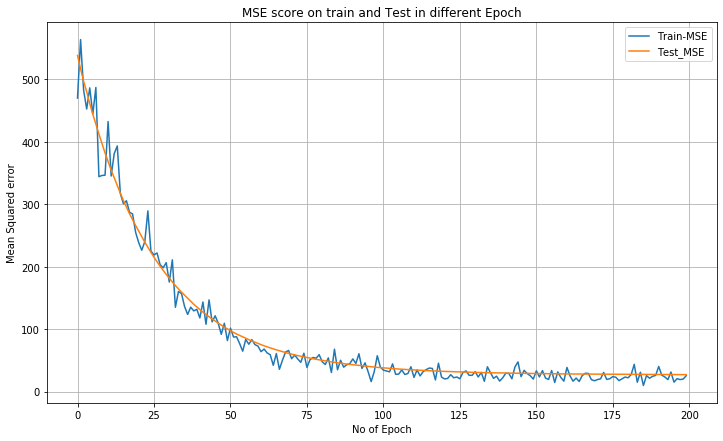

In [47]:
plt.figure(figsize=(12,7))
plt.plot(epoch_list_cons, mse_train_list_cons, label="Train-MSE")
plt.plot(epoch_list_cons, mse_test_list_cons, label="Test_MSE")
plt.xlabel("No of Epoch")
plt.ylabel("Mean Squared error")
plt.title("MSE score on train and Test in different Epoch")
plt.legend()
plt.grid()
plt.show()

#### MSE on test (by our implimentation)

In [48]:
print("MSE of model on Test data is:", compute_error(X_test, y_test, w_constant, b_constant)[0])

MSE of model on Test data is: 27.008251430085807


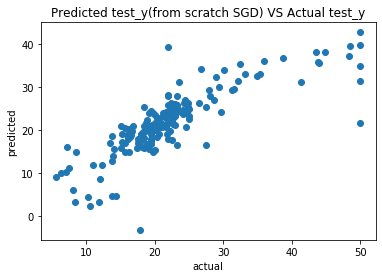

In [54]:
#predicted values of test points by model with constant learning rate.
predicted_points_constant = predict_point(X_test, w_constant, b_constant)
plt.scatter(y_test, predicted_points_constant)
plt.title("Predicted test_y(from scratch SGD) VS Actual test_y")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

### SGD Regressor (SKlearn)


In [55]:
clf = SGDRegressor()
clf.fit(X_train, y_train)
print("MSE on Train:", mean_squared_error(y_train, clf.predict(X_train)))
print("MSE on Test:", mean_squared_error(y_test, clf.predict(X_test)))

MSE on Train: 21.189249163674706
MSE on Test: 25.747633036763148


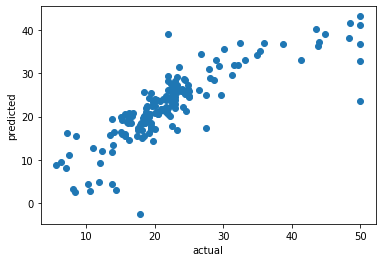

In [56]:
test_predicted_sklearn = clf.predict(X_test)
plt.scatter(y_test, test_predicted_sklearn)
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

In [58]:
x = PrettyTable()

x.field_names = ["MSE", "Model"]
x.add_row(["27", "Scratch SGDRegressor"])
x.add_row(["25", "Sklearn SGDRegressor"])

## Comparing results from both
### Sklearn vs Mine

In [59]:
from prettytable import PrettyTable
print(x)

+-----+----------------------+
| MSE |        Model         |
+-----+----------------------+
|  27 | Scratch SGDRegressor |
|  25 | Sklearn SGDRegressor |
+-----+----------------------+


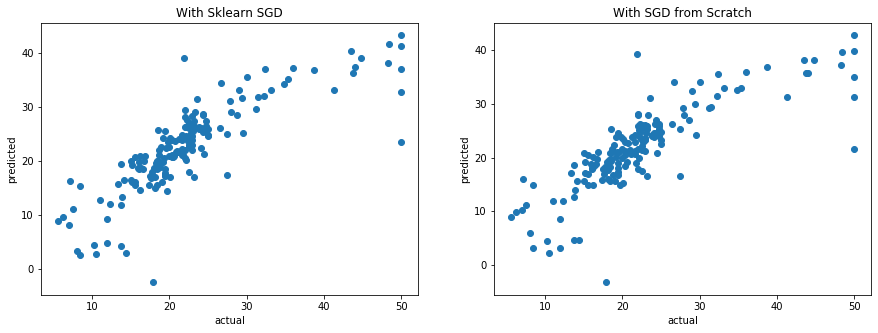

In [76]:
plt.figure(figsize=(23,5))
plt.subplot(131)
plt.scatter(y_test, test_predicted_sklearn)
plt.title("With Sklearn SGD")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.subplot(132)
plt.scatter(y_test, predicted_points_constant)
plt.title("With SGD from Scratch")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

### Conclusion
##### 1. Got results very close to sklearn implimentaion. In above plot of test vs actual we can see both are doing very similar on test points.
##### 2. If we can optimize thise code , add regularizer and try different approach for adaptively reduction in learning rate then can get better result than sklearn implimentation.